<img src='../img/acam_banner.png' alt='ACAM Training School' align='right' width='60%'></img>

<br>

<hr>

# Modern-Era Retrospective analysis for Research and Application (MERRA-2) - Aerosol data 

### About

This notebook demonstrates how to visualize the Modern-Era Retrospective analysis for Research and Applications, Version 2 (MERRA-2) aerosol diagnostics monthly collection M2TMNXAER.5.12.4. M2TMNXAER.5.12.4 is the corresponding hourly collection. 

The example shows you how to visualize spatial maps and time series of surface PM2.5 over the entire region. PM2.5 refers to fine particulate matter with a diameter of 2.5 micrometers or less; it is a type of air pollutant consisting of tiny particles suspended in the air. 

The Modern-Era Retrospective analysis for Research and Applications, Version 2 (MERRA-2) is an updated dataset that starts from 1980 and replaces the original MERRA dataset. It incorporates advancements in assimilation systems, allowing the assimilation of modern hyperspectral radiance, microwave observations, GPS-Radio Occultation datasets, and NASA's ozone profile observations since late 2004. The spatial resolution of MERRA-2 remains similar to MERRA, with a resolution of about 50 km in the latitudinal direction.

MERRA-2 goes beyond meteorological assimilation and aims to provide an Earth System reanalysis. It is the first global reanalysis to assimilate space-based aerosol observations and represent their interactions with other climate processes. Furthermore, MERRA-2 includes a representation of ice sheets in Greenland and Antarctica, making it more comprehensive in its coverage.

You find more information on MERRA-2 products and variables [here](https://gmao.gsfc.nasa.gov/pubs/docs/Bosilovich785.pdf).

### Basic Facts

> **Spatial resolution**: `0.5° x 0.625°` <br>
> **Spatial coverage**: `Global` <br>
> **Temporal resolution**: `Hourly/Daily/Monthly` <br>
> **Temporal coverage**: `1980 - present` <br>
> **Data format**: `netCDF`

### How to access the data

**Register Earthdata login and set up the credential environment**

- Create an Earthdata account and link GES DISC with your account by following the top two (or three) steps in the GES DISC data access instruction page (click [this link](https://disc.gsfc.nasa.gov/data-access)).

**Download MERRA-2 data**

Follow the following instructions to subset and download MERRA-2 data: [How to use the Level 3 and 4 Subsetter and Regridder](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20use%20the%20Level%203%20and%204%20Subsetter%20and%20Regridder). The case presented below reads the data subsetted and downloaded to a disk.



### Module outline
* [1 - Read MERRA-2 areosol data](#read_merra-2_data)
* [2 - Construct the surface PM2.5 from MERRA-2 individual components](#construct_surface_PM2.5)
* [3 - Visualize the evolution of aerosols with maps and time series](#visualize_evolution)
     * [3.1 - Plot the spatial maps](#plot_maps)
     * [3.2 - Plot the time series of monthly mean averaged over the region](#plot_time_series)

<hr>

#### Load required libraries

In [5]:
#from calendar import monthrange

import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy

<hr>

## <a id='read_merra-2_data'></a> Read MERRA-2 areosol data

MERRA-2 areosol data is available in`netCDF` format. Under `../../eodata/acam_training_school/MERRA/*`, monthly MERRA-2 data for two years (2019-2020) were downloaded. 
You can use xarray's function `xr.open_mfdataset` to open the netCDF list of files; this function is used to open and concatenate multiple netCDF files into a single xarray dataset.

Once loaded, you see that the data is organised in three dimensions (lat, lon and time) and six variables.

In [2]:
ds = xr.open_mfdataset('../../eodata/acam_training_school/MERRA/*')
ds

<xarray.Dataset>
Dimensions:    (time: 24, lon: 187, lat: 161)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01T00:30:00 ... 2020-12-01T00:30:00
  * lon        (lon) float64 55.62 56.25 56.88 57.5 ... 170.0 170.6 171.2 171.9
  * lat        (lat) float64 -17.5 -17.0 -16.5 -16.0 ... 61.0 61.5 62.0 62.5
Data variables:
    BCSMASS    (time, lat, lon) float32 dask.array<chunksize=(1, 161, 187), meta=np.ndarray>
    DUSMASS25  (time, lat, lon) float32 dask.array<chunksize=(1, 161, 187), meta=np.ndarray>
    OCSMASS    (time, lat, lon) float32 dask.array<chunksize=(1, 161, 187), meta=np.ndarray>
    SO4SMASS   (time, lat, lon) float32 dask.array<chunksize=(1, 161, 187), meta=np.ndarray>
    SSSMASS25  (time, lat, lon) float32 dask.array<chunksize=(1, 161, 187), meta=np.ndarray>
    TOTEXTTAU  (time, lat, lon) float32 dask.array<chunksize=(1, 161, 187), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    Contact:                           http://gmao.gsfc.nasa.gov
    History:                           Original file generated: Mon Feb 11 23...
    Filename:                          MERRA2_400.tavgM_2d_aer_Nx.201901.nc4
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    ...                                ...
    DataResolution:                    0.5 x 0.625
    identifier_product_doi:            10.5067/FH9A0MLJPC7N
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

The data above has three dimensions (`time`, `latitude`, `longitude`) and six data variables:
* `BCSMASS`: Black Carbon (BC) mass concentration
* `DUSMASS25`: Dust (DUS) mass concentration
* `OCSMASS`: Organic Carbon (OC) mass concentration
* `SO4SMASS`: Sulfate (SO4) mass concentration
* `SSSMASS25`: Sea Salt (SSS) mass concentration
* `TOTEXTTAU`: Total Extinction Aerosol Optical Depth

## <a id='construct_surface_PM2.5'></a> Construct the surface PM2.5 from MERRA-2 individual components 
TOTSPM25 represents the total surface concentration of particulate matter with a diameter of 2.5 micrometers or less (PM2.5) and can be calculated as follows:
<br> <br>
`TOTSPM25 = OCSMASS+ BCSMASS+ SO4SMASS*1.375+ DUSMASS25 + SSSMASS25`
<br><br>
Sulfate requires a multiplication factor since the species tracer in MERRA-2 is the sulfate ion. Unlike with MERRAero, a multiplicative factor is not included for OCSMASS to convert organic carbon to organic matter since this is already handled within the model.
<br><br>
If you want to know more about the particulate matter data from MERRA-2 you can refer to the following article:
[Does MERRA-2 have PM 1.0, PM2.5, and PM10 data?](https://disc.gsfc.nasa.gov/information/faqs?keywords=MERRA-2&title=Does%20MERRA-2%20have%20PM%201.0,%20PM2.5,%20and%20PM10%20data%3F)


In [3]:
sel_var_shortname = "TOTEXTTAU"  # Total aerosol optical depth, an output from MERRA-2 
sel_var_shortname = "TOTSPM25"   # Total surface PM2.5, a derived variable 

if sel_var_shortname == "TOTSPM25":
    sel_var_value = ds["OCSMASS"]+ ds["BCSMASS"]+ ds["SO4SMASS"]*1.375 + ds["DUSMASS25"] + ds["SSSMASS25"]
    sel_var_longname = "Surface PM2.5"
    sel_var_unit = '(kg m-3)' 
else:
    sel_var_value= ds[sel_var_shortname]
    sel_var_longname = sel_var_value.attrs['long_name']
    sel_var_unit = '('+sel_var_value.attrs['units']+')' 
    
print("The selected variable is {}: {}{}".format(sel_var_shortname, sel_var_longname,sel_var_unit))

The selected variable is TOTSPM25: Surface PM2.5(kg m-3)


## <a id='visualize_evolution'></a> Visualize the evolution of aerosols with maps and time series

 

#### <a id='plot_maps'></a> Plot the spatial maps

This code is intended to visualize the progression of Australian bushfires. 
We plot the spatial facet map (e.g., the first three weeks) to visualize the bushfire's spatial distribution.
The resulting plot is saved as a PNG image file, with information about its location for retrieval.
<br>



* `ccrs.PlateCarree()` specifies the data projection.
* `col` parameter sets the variable used for creating subplots along the 'time' dimension, with `col_wrap=3` defining the number of subplots per row.
* `cmap` parameter sets the colormap for the plot. 
* `cbar_kwargs` dictionary configures the colorbar orientation, size, and spacing. 
* `subplot_kws` specifies the projection for each subplot.

We create the main title for the plot by combining the long name and unit of the selected variable; the `for` loop sets the map's options on all axes. We save the plot as a PNG image file with the specified filename and path and finally we display a message indicating the location and filename of the saved plot file for the user to retrieve.

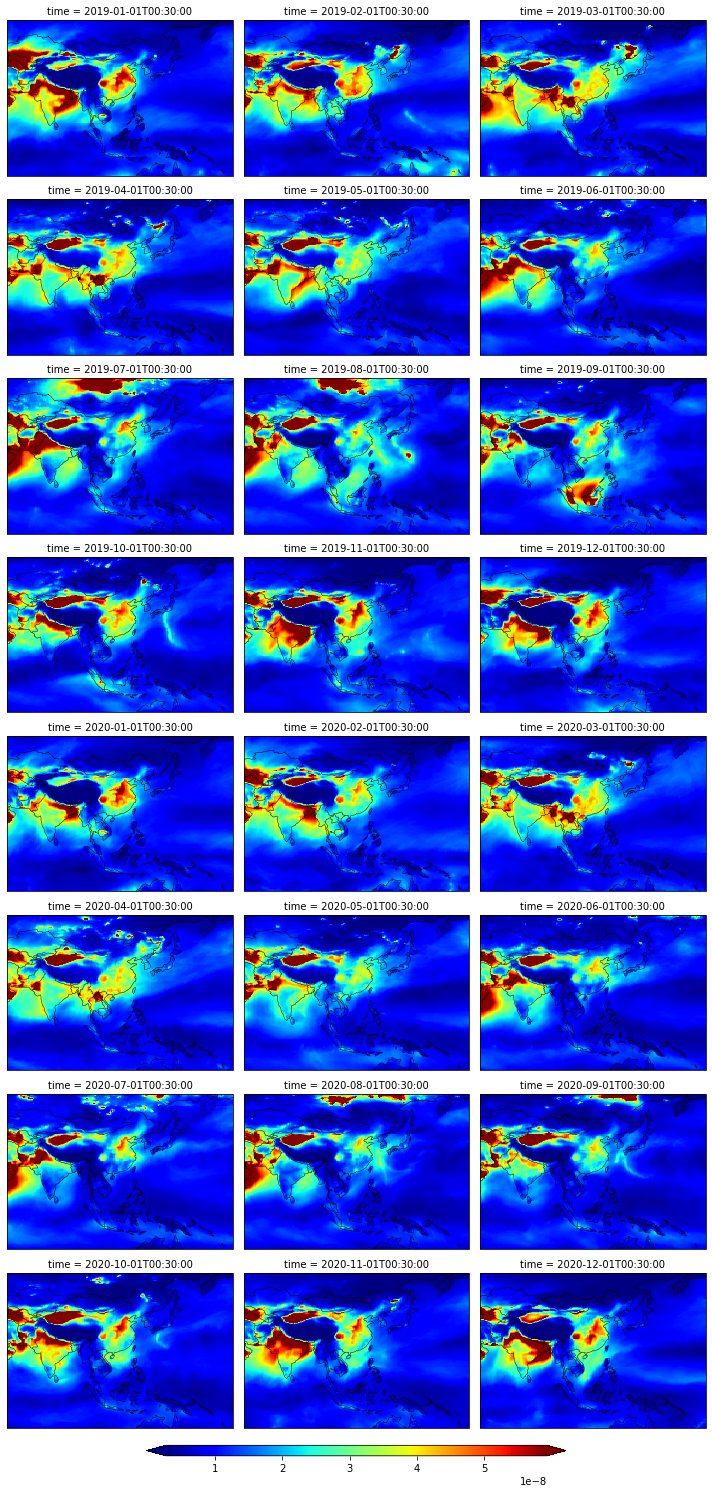

In [6]:
# Zoom in to a focused region
# lon_west_plot_region,lon_east_plot_region = -120, 179.375
# lat_south_plot_region,lat_north_plot_region = -60., 0.


pmap = sel_var_value.plot(transform=ccrs.PlateCarree(),  # the data's projection                                                            
             col='time', col_wrap=3, robust=True, # multiplot settings
             cmap=plt.cm.jet,
             cbar_kwargs={
                 "orientation": "horizontal",
                 "shrink": 0.6,
                 "aspect": 40,
                 "pad": 0.01,
                         },
            subplot_kws={'projection': ccrs.PlateCarree(central_longitude=110)})  # the plot's projection
            # shift the original central longitude from 0 to 180 


# We have to set the map's options on all axes
for ax in pmap.axes.flat:
    ax.coastlines(resolution="110m",linewidth=0.5)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)

 #### <a id='plot_time_series'></a> Plot the time series of monthly mean averaged over one region

Here we plot the time series of monthly mean averaged over the region of East China by setting the variables for the longitude and the latitude. 


##### Define a subset region
In this case a subset of the variable data corresponding to the 'East_China' region is obtained, allowing for more focused analysis and visualization of that specific region.

In [7]:
# Subset region 
sel_region = 'East_China'

if sel_region == "East_China":
    lon_west_sel_region, lon_east_sel_region = 105, 120
    lat_south_sel_region,lat_north_sel_region = 25, 35

#dlon_sel_region = lon_east_sel_region - lon_west_sel_region
#dlat_sel_region = lat_north_sel_region - lat_south_sel_region
print('sel_region:', sel_region)
print('lon:', lon_west_sel_region, lon_east_sel_region)
print('lat:', lat_south_sel_region,lat_north_sel_region)

sel_region: East_China
lon: 105 120
lat: 25 35


In [8]:
sel_var_value_region = sel_var_value.sel(lon=slice(lon_west_sel_region, lon_east_sel_region), lat=slice(lat_south_sel_region,lat_north_sel_region))
sel_var_value_region

<xarray.DataArray (time: 24, lat: 21, lon: 25)>
dask.array<getitem, shape=(24, 21, 25), dtype=float32, chunksize=(1, 21, 25), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T00:30:00 ... 2020-12-01T00:30:00
  * lon      (lon) float64 105.0 105.6 106.2 106.9 ... 118.1 118.8 119.4 120.0
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 33.0 33.5 34.0 34.5 35.0

The variable `sel_var_value_region` is created by applying the `sel` method to the original variable `sel_var_value`. This method selects a subset of the variable based on the specified longitude and latitude boundaries using the `slice` function.

##### Plot the time series of daily mean averaged over the selected region
This code segment generates a time series plot, computes statistics, and saves the plot as an image file, providing an overview of the monthly mean data averaged over the selected region.

stat:
count    2.400000e+01
mean     3.320877e-08
std      6.637039e-09
min      2.087948e-08
25%      2.662391e-08
50%      3.472024e-08
75%      3.832477e-08
max      4.249402e-08
dtype: float64


Text(0, 0.5, 'TOTSPM25(kg m-3)')

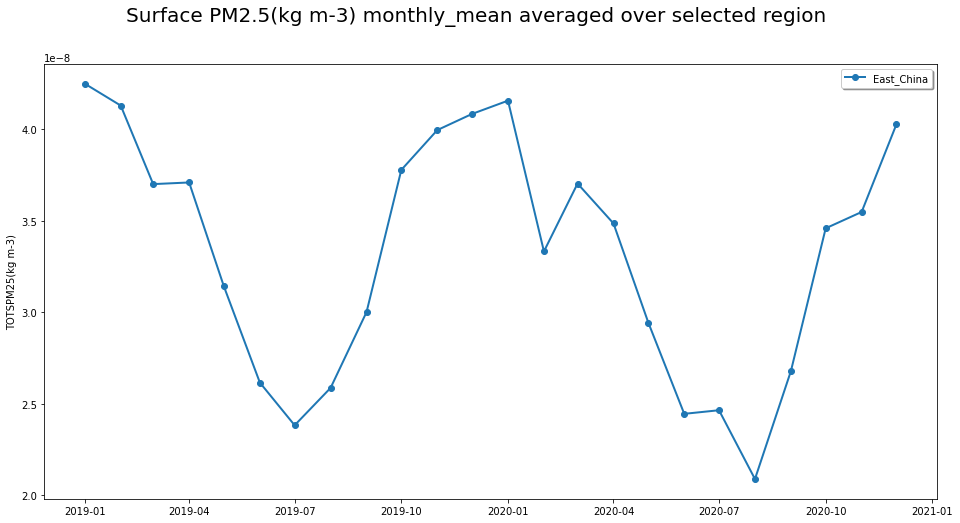

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
sel_var_value_mean_region = sel_var_value_region.groupby('time').mean(dim=['lat','lon'],skipna=True)

# Convert to dataframe 
plotdata = sel_var_value_mean_region.to_pandas()

# List the statistics
stat = plotdata.describe()
print("stat:")
print(stat)

# Plot time series
ax.plot(plotdata,label=sel_region, marker="o", linewidth=2)
ax.legend(shadow=True, fancybox=True)

# Plot main title and xy labels
main_title = "{}{} monthly_mean averaged over selected region".format(sel_var_longname, sel_var_unit, sel_region) 
plt.suptitle(main_title, fontsize=20)
ax.set_ylabel(sel_var_shortname+sel_var_unit)


<hr>

### References
* [Does MERRA-2 have PM 1.0, PM2.5, and PM10 data?](https://disc.gsfc.nasa.gov/information/faqs?keywords=MERRA-2&title=Does%20MERRA-2%20have%20PM%201.0,%20PM2.5,%20and%20PM10%20data%3F)
* [How can I subset and download a large amount of the MERRA-2 data?](https://disc.gsfc.nasa.gov/information/faqs?keywords=MERRA-2&title=How%20can%20I%20subset%20and%20download%20a%20large%20amount%20of%20the%20MERRA-2%20data%3F)
* [Time-series in xarray](http://xarray.pydata.org/en/stable/time-series.html) 
* [Statistical Operations, Resampling and Climatologies Using Xarray](https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_07_Xarray_statistical_resample_roll_climatology_CMIP6.html)
* [Xarray plotting and visualization](https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html)

<hr>

<img src='../img/acam_banner.png' alt='Logo EU Copernicus' align='left' width='30%'><br><br><br><br><br>
This project is licensed under <a href="../LICENSE">MIT License</a> and is developed under a Copernicus contract.

<p style="text-align:right;"> <a href='https://training.eumetsat.int'>EUMETSAT Training</a> | <a href='mailto:training@eumetsat.int'>Contact the training team</a></p>